# PyLAR
## [Python utilities for the LAR model](https://github.com/seap-udea/pylar)

### Figures for the LAR-SMZG-HESS2024

Use this notebook to generate the figures of the paper:

> Juan F. Salazar, Rubén D. Molina, Jorge I. Zuluaga, and Jesus D. Gomez-Velez (2024), **Wetting and drying trends in the land–atmosphere reservoir of large basins around the world**, [Hydrology and Earth System Sciences, in publication (2024)](https://hess.copernicus.org/preprints/hess-2023-172/), [doi.org/10.5194/hess-2023-172](https://doi.org/10.5194/hess-2023-172).


In [1]:
import ipylar as lar
%load_ext autoreload 
%autoreload 

Loading iPyLAR version 1.0.1


## Figures: timeseries, accumulation, release

### Required packages and data

In [1]:
#External packages
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict as Dict
from scipy.interpolate import interp1d
import mpmath as mp
import numpy as np
from datetime import datetime,timedelta
import pytz
import matplotlib.dates as mdates
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from scipy.signal import lombscargle
from scipy.optimize import minimize
from scipy import signal as sg
import sympy as sp
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import trapezoid
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import multivariate_normal
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties
import matplotlib

## Useful constants and routines

In [2]:
COLAB=0
#Constants
rad=180/np.pi
deg=1/rad
UTCL=5*3600
hours=3600
days=86400
years=365.25*days

#Data source
lar_figdir="figures/"
lar_datadir="data/"

#Safe colors
Qcolor="#d95f02"
Rcolor="#7570b3"

#Common strings
nam_nablaq="Moisture convergence"
str_nablaq=r"$Q$"
nam_R="River discharge"
str_R=r"$R$"
sty_nq=dict(color=Rcolor,alpha=1)
sty_R=dict(color=Qcolor,alpha=1)
lab_nq=rf"{nam_nablaq} ({str_nablaq})"
lab_R=rf"{nam_R} ({str_R})"

#Units
nam_flu="Flux"
UQ=1e9/(365.25*86400) #dam^3 -> m^3
uflux=r"$10^3$ km$^3$/yr"
#Time
utime="d"
UT=1
#Total stored
UI=1e3 #km^3 -> 10^3 km^3

# Accumulation, release
acc_color='#66c2a5'
rel_color='#fc8d62'

def figsize(sx,sy):
    if COLAB:
        DPIX=2
        DPIY=1
    else:
        DPIX=1
        DPIY=1
    return (sx*DPIX,sy*DPIY)

def tight_layout(fig):
    fig.tight_layout()
    
def save_fig(fig):
    try:
        print(f"Saving plot as '{fig.name}'")
        fig.savefig(f"{lar_figdir}/{fig.name}")
    except:
        pass
    
def set_xdates(ax):
    locator=mdates.AutoDateLocator(minticks=5,maxticks=50)
    formatter=mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x',rotation=90)
    ax.margins(0)
    
class Basin(object):
    def __init__(self):
            pass

def trapezoid_int(f,a,b,dx):
    xs=np.arange(a,b+dx/2,dx)
    ys=f(xs)
    I=trapezoid(ys,xs)
    return I

### Read data

In [3]:
#############################################
#BASINS
#############################################
basin_data=Dict(
    amazonas=Dict(name="Amazon basin",qsrc="ERA5",rsrc="HYBAM",drgs=[1997,2001,2005,2007,2010,2015]),
    parana=Dict(name="Parana basin",qsrc="ERA5",rsrc="GRDC",drgs=[]),
    congo=Dict(name="Congo basin",qsrc="ERA5",rsrc="GRDC",drgs=[]),
    mississippi=Dict(name="Mississippi basin",qsrc="ERA5",rsrc="GRDC",drgs=[]),
    ob=Dict(name="Ob basin",qsrc="ERA5",rsrc="GRDC",drgs=[]),
    yenisei=Dict(name="Yenisei basin",qsrc="ERA5",rsrc="GRDC",drgs=[]),
)
bmap=list(matplotlib.colormaps['Set1'].colors)
bmap.remove(bmap[5])
for i,basin in enumerate(basin_data.keys()):
    basin_data[basin]["color"]=bmap[i]

In [9]:
def time_interpolation_function(times,values):
    interp_basic = interp1d(times,values,kind='slinear')
    def interp_fun(t):
        if interp_basic.x[0]<t<interp_basic.x[-1]:
            return interp_basic(t)
        else:
            return np.nan
    return interp_fun

def read_basin_data(key,full,qsource,rsource,kind_interp='linear'):
    
    #Create basin
    basin=Basin()
    basin.key=key
    basin.full=full
    basin.qsource=qsource
    basin.rsource=rsource
    
    #Read Data
    source=f"era5/{basin.key}_output.csv"
    data=pd.read_csv(f"{lar_datadir}/{source}")
    
    #Average of divergence over 3 hours
    fackg=3*hours*1e3
    
    #Read errors
    source=f"vimd/{basin.key}_monthly.csv"
    data_errors=pd.read_csv(f"{lar_datadir}/{source}",index_col=0)
    data_errors["nqdiv"]=data_errors.ensemble_mean/fackg
    data_errors["dnqdiv"]=data_errors.ensemble_spread/fackg
    data_errors["relerr"]=data_errors.ensemble_spread/abs(data_errors.ensemble_mean)
    data_errors["date"]=data_errors.apply(lambda row:f"{row.year:.0f}-{row.month:.0f}-16",axis=1)
    data_errors["datestd_err"]=data_errors["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
    data_errors["datetime"]=data_errors["datestd_err"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data_errors["time"]=data_errors["datetime"].apply(lambda d:d.timestamp()+UTCL)
    data_errors.set_index("datestd_err",drop=False,inplace=True)
    columns_err=["time","datestd_err","nqdiv","dnqdiv","relerr"]
    
    #Dates
    data["datestd"]=data["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
    data["datetime"]=data["datestd"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data["time"]=data["datetime"].apply(lambda d:d.timestamp()+UTCL)
    
    #Numeric columms
    columns=['water_vap','water_liq','water_ice']
    data.dropna(subset=columns,inplace=True)
    try:
        for col in columns:
            data[col]=data[col].str.replace(",",".").astype("float")
    except:
        pass
    for col in columns:
        data[col]=pd.to_numeric(data[col],errors='coerce').interpolate()
    #Consolidate columns
    data_atm=data.copy()
    data_atm.set_index(data["datestd"],inplace=True)
    data_atm["nq_mass"]=data_atm[columns].sum(axis=1)
    data_atm["nq"]=data_atm["nq_mass"]/1e3
    #Error
    vnq=0.05 #Molina, according to analysis of uncertainties in data processing of ERA5
    data_atm["dnq"]=vnq*abs(data_atm["nq_mass"])/1e3

    if basin.rsource == "GRDC":
        #Read Data
        source=f"era5/{basin.key}_output.csv"
        data=pd.read_csv(f"{lar_datadir}/{source}")
        #Dates
        data["datestd"]=data["date"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-16"))
        columns=["discharge"]
    elif basin.rsource == "HYBAM":
        #Only for Amazon River
        RSOURCE="HYBAM"
        source=f"era5/{basin.key}_hybam_output.xlsx"
        data=pd.read_excel(f"{lar_datadir}/{source}")
        data["datestd"]=data.apply(lambda x:f"{x.V1:.0f}-{x.V2:02.0f}-16",axis=1)
        columns=["V4"]

    #Date
    data["datetime"]=data["datestd"].apply(lambda d:datetime.strptime(d,"%Y-%m-%d"))
    data["time"]=data["datetime"].apply(lambda d:d.timestamp()+UTCL)
    
    #Numeric columns
    data.dropna(subset=columns,inplace=True)
    try:
        for col in columns:
            data[col]=data[col].str.replace(",",".").astype("float")
    except:
        pass
    for col in columns:
        data[col]=pd.to_numeric(data[col],errors='coerce').interpolate()
    #Consolidate data
    data_riv=data.copy()
    data_riv.set_index(data["datestd"],inplace=True)
    data_riv["R"]=data_riv[columns].sum(axis=1)
    
    #Error
    vR=0.15 #According to T. H. Syed, J. S. Famiglietti, et al. (in case of Amazonas)
    data_riv["dR"]=vR*abs(data_riv["R"])

    # Merge data
    data_merge=pd.DataFrame()
    merge=data_atm.merge(data_riv,left_index=True,right_index=True)
    data_merge["datestd"]=merge["datestd_x"]
    data_merge.set_index(data_merge["datestd"],inplace=True)
    data_merge["datetime"]=merge["datetime_x"]
    data_merge["time"]=merge["time_x"]
    data_merge["R"]=merge["R"]
    data_merge["dR"]=merge["dR"]
    data_merge["nq"]=merge["nq"]
    data_merge["dnq"]=merge["dnq"]

    #Reference
    data_merge["Rref"]=merge["R"]
    data_merge["nqref"]=merge["nq"]
    
    # Save data
    basin.data_merge=data_merge
    #basin.data=data_merge
    basin.columns_err=columns_err
    basin.data=pd.merge(data_merge,data_errors[columns_err],how="left",on="time")
    basin.data.set_index("datestd",drop=False,inplace=True)
    basin.tini=float(data_merge["time"].iloc[0])
    basin.tend=float(data_merge["time"].iloc[-1])
    basin.dini=data_merge["datetime"].iloc[0]
    basin.tspan=data_merge["time"].iloc[-1]-data_merge["time"].iloc[0]
    basin.yspan=basin.tspan/years
    basin.dspan=basin.tspan/days
    basin.data_errors=data_errors

    #Global properties
    basin.ndata=len(data_merge)
    basin.nmerge=len(data_merge)
    basin.nerror=len(data_errors[(data_errors.time>=basin.tini)&(data_errors.time<=basin.tend)])
    basin.vnq=vnq
    basin.vR=vR

    #Correlation
    """
    Cov = 
    [ 
    sigma_x^2  rho_xy sigma_x sigma _y
    rho_xy sigma_x sigma _y  sigma_y^2
    ]
    """
    Cov=np.cov(basin.data["R"],basin.data["nq"])
    """
    rho_xy = Cov[0,1]/(sigma_x*sigma_y)
    sigma_x = Cov[0,0]**0.5
    sigma_y = Cov[1,1]**0.5
    """
    basin.rhoRnq=Cov[0,1]/(Cov[0,0]*Cov[1,1])**0.5
    
    #Basin color
    basin.color=basin_data[key]["color"]
    
    #Detection
    basin.detection=False
    
    #Extract errors from data_errors
    basin.data.dnq=basin.data.dnqdiv
    basin.vnq=None
    
    #Random seed
    basin.seed=hash(basin)%(2**32-1)
    
    #Data global properties
    print(f"*"*40)
    print(f"{basin.key}")
    print(f"Number of data points: merge = {basin.nmerge}, error = {basin.nerror}, total = {basin.ndata}")
    print(f"Initial time: {basin.tini}")
    print(f"Initial date: {basin.dini}")
    print(f"Total data points: {basin.ndata}")
    print(f"Time span: {basin.yspan} a = {basin.dspan} d")
    print(f"Signal correlation (R - nq): {basin.rhoRnq}")
    
    return basin

def plot_basin_series(basin,ti_win=2000,dt_win=5,kind_interp='cubic',over_interp=10,show_ref=False):

    #Interpolation
    basin.Rint=interp1d(basin.data["time"],basin.data["R"],kind=kind_interp)
    basin.nqint=interp1d(basin.data["time"],basin.data["nq"],kind=kind_interp)
    
    #Full signal
    tfulls=np.linspace(basin.data["time"].iloc[0],basin.data["time"].iloc[-1],over_interp*basin.ndata)
    dfulls=[datetime.fromtimestamp(t) for t in tfulls]
    Rfulls=basin.Rint(tfulls)
    nqfulls=basin.nqint(tfulls)

    #Plot full signal
    fig,axs=plt.subplots(2,1,figsize=figsize(9,8))

    #Full panel
    ax=axs[0]

    ax.plot(basin.data["datetime"],basin.data["nq"]/UQ/UI,label=lab_nq,**sty_nq)
    ax.plot(basin.data["datetime"],basin.data["R"]/UQ/UI,label=lab_R,**sty_R)

    if show_ref:
        ax.plot(basin.data["datetime"],basin.data["nqref"]/UQ/UI,label=f"{str_nablaq} ref.",**sty_nq,ls=':')
        ax.plot(basin.data["datetime"],basin.data["R"]/UQ/UI,label=f"{str_R} ref.",**sty_R,ls=":")
        
    ax.set_ylabel(f"Flux [{uflux}]");
    legend=ax.legend(loc=(0.0,1),ncol=6,frameon=False);

    #Zoom
    ax=axs[1]
    ax.plot(dfulls,nqfulls/UQ/UI,label=rf"{nam_R} ({str_R})",**sty_nq)
    ax.errorbar(basin.data["datetime"],basin.data["nq"]/UQ/UI,yerr=basin.data["dnq"]/UQ/UI,ls='None',capsize=5,**sty_nq)
    ax.plot(dfulls,Rfulls/UQ/UI,label=rf"{nam_R} ({str_R})",**sty_R)
    ax.errorbar(basin.data["datetime"],basin.data["R"]/UQ/UI,yerr=basin.data["dR"]/UQ/UI,ls='None',capsize=5,**sty_R)
    
    if show_ref:
        #Interpolation
        basin.Rint=interp1d(basin.data["time"],basin.data["Rref"],kind=kind_interp)
        basin.nqint=interp1d(basin.data["time"],basin.data["nqref"],kind=kind_interp)

        #Full signal
        tfulls=np.linspace(basin.data["time"].iloc[0],basin.data["time"].iloc[-1],over_interp*basin.ndata)
        dfulls=[datetime.fromtimestamp(t) for t in tfulls]
        Rfulls=basin.Rint(tfulls)
        nqfulls=basin.nqint(tfulls)

        ax.plot(dfulls,nqfulls/UQ/UI,**sty_nq,ls=":")
        ax.errorbar(basin.data["datetime"],basin.data["nqref"]/UQ/UI,yerr=basin.data["dnq"]/UQ/UI,ls='None',capsize=5,**sty_nq)
        ax.plot(dfulls,Rfulls/UQ/UI,**sty_R,ls=":")
        ax.errorbar(basin.data["datetime"],basin.data["Rref"]/UQ/UI,yerr=basin.data["dR"]/UQ/UI,ls='None',capsize=5,**sty_R)

    ax.set_ylabel(f"Flux [{uflux}]");
    ti_win=datetime(ti_win,1,1)
    dt_win=relativedelta(years=dt_win)
    ax.set_xlim(ti_win,ti_win+dt_win)

    #Source
    ax.text(0.98,0.98,f"Source: {basin.rsource}/{basin.qsource}",
            ha='right',va='top',transform=ax.transAxes,fontsize=8)

    #Decoration
    for ax in axs:
        locator=mdates.AutoDateLocator(minticks=5,maxticks=50)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)
        ax.margins(0)

    axs[0].set_title(f"{basin.full}",pad=30)
    fig.name=f"{basin.key}-full_signal.png"
    tight_layout(fig);  

def modify_basin_errors(basin,vnq=None,vR=None):
    """
    Default values:
        vnq=0.05 #Molina, according to analysis of uncertainties in data processing of ERA5
        vR = 0.15 #According to T. H. Syed, J. S. Famiglietti, et al. (in case of Amazonas)
    """   
    basin.vnq=vnq
    basin.vR=vR
    if vnq:
        basin.data["dnq"]=vnq*abs(basin.data["nq"])
    if vR:
        basin.data["dR"]=vR*abs(basin.data["R"])
        
def basin_storage(basin,ts):
    n=len(ts)
    kind_interp="linear"
    basin.Rint=interp1d(basin.data["time"],basin.data["R"],kind=kind_interp)
    basin.nqint=interp1d(basin.data["time"],basin.data["nq"],kind=kind_interp)
    AlmFun=lambda t:basin.nqint(t)-basin.Rint(t)
    Is=np.array([trapezoid_int(AlmFun,ts[i],ts[i+1],days)/1e9 for i in range(n-1)])
    Ss=np.cumsum(Is)
    ts=(ts[1:]+ts[:-1])/2
    return ts,Is,Ss

In [10]:
#amazonas=Dict(name="Amazon",qsrc="ERA5",rsrc="HYBAM",drgs=[1997,2001,2005,2007,2010,2015]),
basins=dict()
for key in basin_data.keys():
    basins[key]=read_basin_data(key,
                                basin_data[key]["name"],
                                basin_data[key]["qsrc"],
                                basin_data[key]["rsrc"])    

****************************************
amazonas
Number of data points: merge = 492, error = 492, total = 492
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 492
Time span: 40.91444216290212 a = 14944.0 d
Signal correlation (R - nq): -0.091294406770398
****************************************
parana
Number of data points: merge = 428, error = 428, total = 428
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 428
Time span: 35.58110882956879 a = 12996.0 d
Signal correlation (R - nq): -0.017824839827840985
****************************************
congo
Number of data points: merge = 384, error = 384, total = 384
Initial time: 285310800.0
Initial date: 1979-01-16 00:00:00
Total data points: 384
Time span: 31.915126625598905 a = 11657.0 d
Signal correlation (R - nq): 0.34386320649854707
****************************************
mississippi
Number of data points: merge = 504, error = 504, total = 504
Initial time: 285310800.0
Initi

In [11]:
basins['amazonas'].data.describe()

,datetime,time,R,dR,nq,dnq,Rref,nqref,nqdiv,dnqdiv,relerr
count,492,4.920000e+02,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,1999-07-01 19:48:17.560975616,9.308765e+08,174375.401870,26156.310280,186730.538470,21795.889685,174375.401870,186730.538470,-184444.873784,21795.889685,0.582908
min,1979-01-16 00:00:00,2.853108e+08,61866.670000,9280.000500,-36372.142756,14592.994332,61866.670000,-36372.142756,-469211.424445,14592.994332,0.060213
25%,1989-04-08 06:00:00,6.080364e+08,129412.900000,19411.935000,93661.654774,19396.635692,129412.900000,93661.654774,-275615.922687,19396.635692,0.088166
50%,1999-07-01 00:00:00,9.308052e+08,176004.520000,26400.678000,186733.496914,22437.574467,176004.520000,186733.496914,-187030.178141,22437.574467,0.118781
75%,2009-09-23 12:00:00,1.253725e+09,222174.190000,33326.128500,277653.620852,24150.736955,222174.190000,277653.620852,-91326.931290,24150.736955,0.216671
max,2019-12-16 00:00:00,1.576472e+09,271396.770000,40709.515500,455341.963605,28252.740833,271396.770000,455341.963605,57827.899014,28252.740833,115.275404
std,NaN,3.738845e+08,52367.853086,7855.177963,105068.700120,3136.967897,52367.853086,105068.700120,110791.815570,3136.967897,5.353215


### Detect accumulation release

In [12]:
def detect_accumulation_release(basin,istart=1,verbose=False,advance=True):    
    ###############################
    # CROSSINGS
    ###############################
    #Interpolation
    kind_interp="linear"
    basin.Rint=interp1d(basin.data["time"],basin.data["R"],kind=kind_interp)
    basin.nqint=interp1d(basin.data["time"],basin.data["nq"],kind=kind_interp)
    
    #Storage function
    def AlmFun(t):
        A=basin.nqint(t)-basin.Rint(t)
        return A

    #Intersection points
    ts=np.array(basin.data["time"])
    Qs=np.array(basin.data["nq"])
    Rs=np.array(basin.data["R"])
    ds=Qs-Rs

    sgnp=np.sign(ds[0])
    trs=[-1e100]
    for i,d in enumerate(ds):
        sgn=np.sign(d)
        if (sgn*sgnp<0):
            tr=-ds[i-1]*(ts[i]-ts[i-1])/(ds[i]-ds[i-1])+ts[i-1]
            if (tr-trs[-1])>50*days:
                trs+=[tr]
        i+=1
        sgnp=sgn
    trs=np.array(trs[1:])

    #Selected points
    trs=trs[istart:]
    NR=len(trs)
    if verbose:print(f"Found {NR} intersections")
    basin.NR=NR
    
    ###############################
    # COMPUTE ACCUMULATION
    ###############################
    #Evaluate the type of period
    sgnp=0
    tacus=[]
    Iacus=[]
    trels=[]
    Irels=[]
    if verbose or not advance:
        ies=range(1,NR)
    else:
        ies=tqdm(range(1,NR))

    for i in ies:
        evalue=False

        #Compute accumulation
        #I=quad(AlmFun,trs[i-1],trs[i])[0]/1e9 #10^9 = (10^3)^3 (km^3) 
        I=trapezoid_int(AlmFun,trs[i-1],trs[i],days)/1e9 #10^9 = (10^3)^3 (km^3) 

        #Determine the sign of the integral
        sgn=np.sign(I)
        if i==1:
            if verbose:print("First value")
            sgnp=sgn
            evalue=1
        #Change of sign respect to previous
        elif sgn*sgnp<0:
            evalue=1
            if verbose:print(f"Change of sign in {i} with integral {I}")
        #No change of sign
        else:
            evalue=2
            if verbose:print(f"No change of sign in {i} with integral {I}")

        #If accumulate
        if evalue:
            if sgn>0:
                #If evalue = 2 is because the previous has the same sign
                if evalue==1:
                    tacus+=[trs[i-1]]
                    Iacus+=[I]
                else:
                    Iacus[-1]+=I
                if verbose:print(f"Storing acummulation integral {i} (t in [{trs[i-1]},{trs[i]}]): {Iacus[-1]}")
            else:
                #If evalue = 2 is because the previous has the same sign
                if evalue==1:
                    trels+=[trs[i-1]]
                    Irels+=[I]
                else:
                    Irels[-1]+=I
                if verbose:print(f"Storing release integral {i} (t in [{trs[i-1]},{trs[i]}]): {Irels[-1]}")
        sgnp=sgn

    #Check the latest point
    #I=quad(AlmFun,trs[-2],trs[-1])[0]/1e9
    I=trapezoid_int(AlmFun,trs[-2],trs[-1],days)/1e9
    if sgn>0:
        trels+=[trs[-1]]
        Irels+=[I]
    else:
        tacus+=[trs[-1]]
        Iacus+=[I]

    trels=np.array(trels)
    tacus=np.array(tacus)
    Irels=np.array(Irels)
    
    #Restrict trels to intervals of tacus
    cond=(trels>tacus[0])&(trels<tacus[-1])
    trels=trels[cond]
    Irels=Irels[cond]
    
    ###############################
    # COMPUTE ACCUMULATION
    ###############################
    S=0
    Ss=[]
    tas=[]
    dtas=[]
    trs=[]
    dtrs=[]
    tns=[]
    for i in range(len(tacus)-1):
        #Accumulation
        t=(tacus[i]+trels[i])/2
        tas+=[t]
        dta=abs(trels[i]-tacus[i])/86400
        dtas+=[dta]
        Ia=Iacus[i]
        if verbose:print(f"Accumulation {i} (t in [{tacus[i]},{trels[i]}]) : {Iacus[i]}")
        #Release
        t=(trels[i]+tacus[i+1])/2
        trs+=[t]
        dtr=abs(tacus[i+1]-trels[i])/86400
        dtrs+=[dtr]
        Ir=Irels[i]
        if verbose:print(f"Release {i} (t in [{trels[i]},{tacus[i+1]}]) : {Irels[i]}")
        #Net
        t=(tacus[i]+tacus[i+1])/2
        tns+=[t]
        S+=Ia+Ir
        Ss+=[S]
    
    basin.nper=i+1
    basin.detection=True
    basin.tns=np.array(tns)
    basin.dtns=[datetime.fromtimestamp(t) for t in basin.tns]
    basin.Ss=np.array(Ss)
    
    #Auxiliar
    basin.trs=np.array(trs)
    basin.tas=np.array(tas)
    basin.dtas=np.array(dtas)
    basin.dtrs=np.array(dtrs)
    basin.Iacus=np.array(Iacus)
    basin.Irels=np.array(Irels)
    basin.trels=trels
    basin.tacus=tacus

In [13]:
for key,basin in basins.items():
    detect_accumulation_release(basin)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:00<00:00, 13661.68it/s]


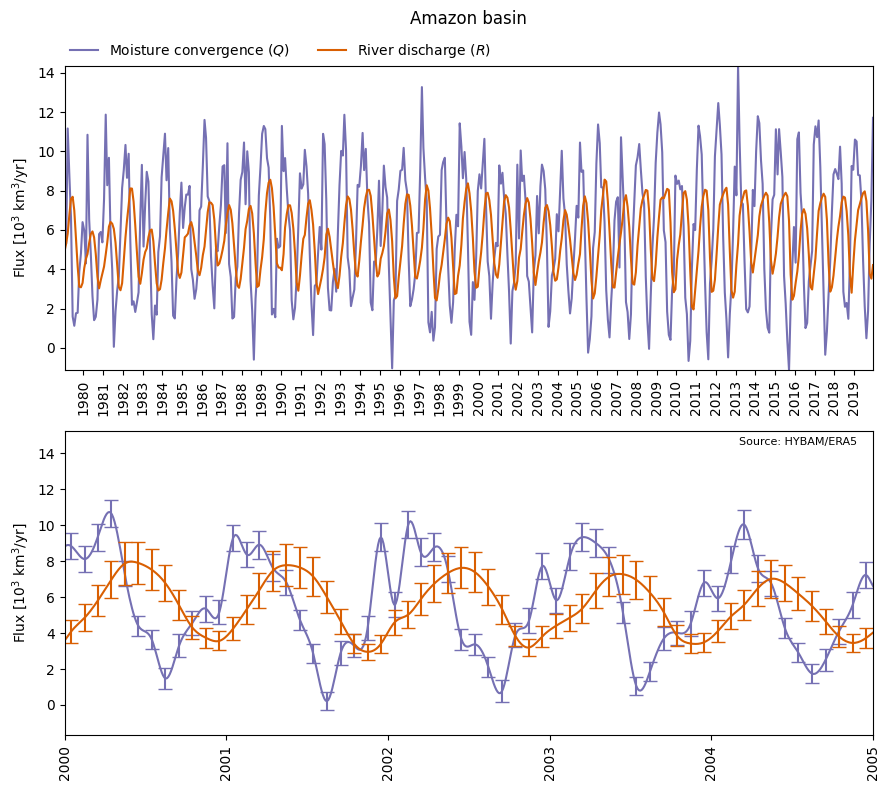

In [14]:
plot_basin_series(basins["amazonas"])

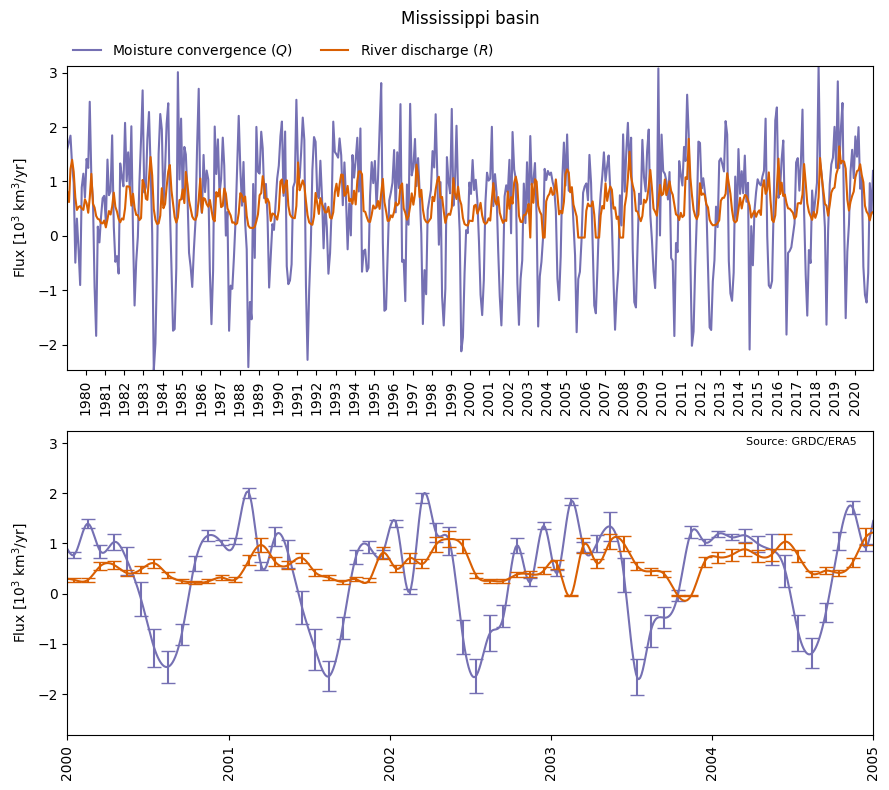

In [15]:
plot_basin_series(basins["mississippi"])

### Random basin realization

In [11]:
def basin_random_realization(basin):
    """
    Errors assuming normal distribution
    """
    basinreal=deepcopy(basin)
    
    #Covariance matrix
    for index in basin.data.index:
        row=basin.data.loc[index]
        rho=basin.rhoRnq
        cov=np.array([
            [row.dR**2,rho*row.dR*row.dnq],
            [rho*row.dR*row.dnq,row.dnq**2]
        ])
        ran=np.random.multivariate_normal([row.R,row.nq],cov,1)
        basinreal.data.loc[index,"R"]=ran[0][0]
        basinreal.data.loc[index,"nq"]=ran[0][1]
    
    return basinreal

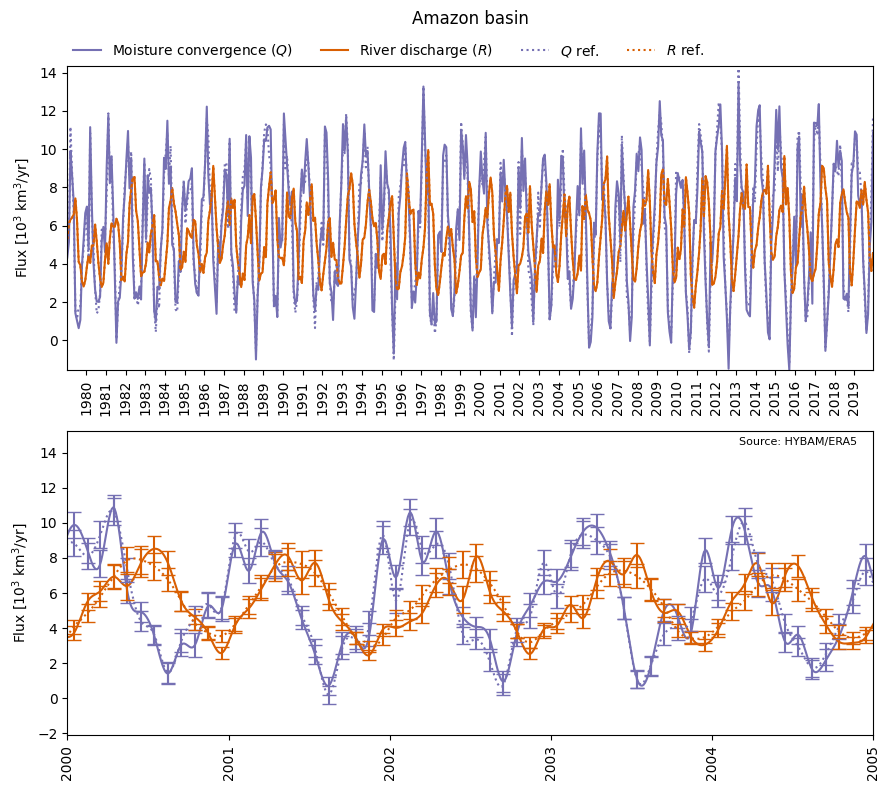

In [12]:
modify_basin_errors(basins["amazonas"],vR=0.1)
basinreal=basin_random_realization(basins["amazonas"])
plot_basin_series(basinreal,show_ref=True)

In [13]:
class BasinSet(object):
    def __init__(self,N):
        self.N=N
        self.set=[]

def storage_error_band(basin,seed=None,N=50):

    #Seed
    np.random.seed(seed)
    
    #Generate realizations
    i=0
    basinset=BasinSet(N)
    basinset.basin=basin
    pbar=tqdm(total=N,position=0)
    ndrop=0
    while True:
        if i>N:break
        basinreal=basin_random_realization(basin)
        try:
            detect_accumulation_release(basinreal,advance=False)
        except:
            ndrop+=1
            continue
        basinset.set+=[basinreal]
        i+=1
        pbar.update()    
    pbar.close()
    print(f"Dropped data: {ndrop}")
    #Compute extrema
    tmin_max=-1e100
    tmax_min=+1e100
    Sfuns=[]
    for basinreal in basinset.set:
        Sfuns+=[interp1d(basinreal.tns,basinreal.Ss,kind="slinear")]
        tmin_max=basinreal.tns[0] if basinreal.tns[0]>tmin_max else tmin_max
        tmax_min=basinreal.tns[-1] if basinreal.tns[-1]<tmax_min else tmax_min
    basinset.treals=np.linspace(tmin_max,tmax_min,100)
    basinset.dreals=[datetime.fromtimestamp(t) for t in basinset.treals]
    Sreals=[]
    for Sfun in Sfuns:
        Sreals+=[Sfun(basinset.treals)]
    basinset.Sreals=np.array(Sreals)

    Squant=np.quantile(basinset.Sreals,[0.05,0.95],axis=0)
    basinset.Smins=Squant[0]
    basinset.Smaxs=Squant[1]
    
    basinset.color=basin.color
    basinset.vR=basinset.basin.vR
    basinset.vnq=basinset.basin.vnq

    return basinset

def plot_basinset(basinset,quantile=[0.05,0.95],plot_all=False):
    
    plt.close("all")
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    
    ax.fill_between(basinset.dreals,basinset.Smins/UI,basinset.Smaxs/UI,color=basinset.color,alpha=0.2)
    if plot_all:
        for basinreal in basinset.set:
            #ax.plot(basinreal.dtns,basinreal.Ss/UI,'-',color=basinset.color,alpha=0.05)
            ax.plot(basinreal.dtns,basinreal.Ss/UI,'-',color='k',alpha=0.01,zorder=-100)
            
    ax.plot(basinset.basin.dtns,basinset.basin.Ss/UI,'-',color=basinset.color,lw=5)
    ax.set_ylabel(rf"Stored [$\times 10^3$ km$^3$]")
    ax.margins(0)
    ax.grid()
    
    vRstr=vnqstr=""
    vRfil=vnqfil=""
    if basinset.basin.vR:
        vRstr=f"$\epsilon_R$ = {basinset.basin.vR*100:.0f}%"
        vRfil=f"-vR_{basinset.basin.vR*100:.0f}"
    if basinset.basin.vnq:
        vnqstr=f"$\epsilon_Q$ = {basinset.basin.vnq*100:.0f}%"
        vnqfil=f"-vnq_{basinset.basin.vnq*100:.0f}"
        
    ax.set_title(rf"{basinset.basin.full}, {vRstr} {vnqstr}")
    
    fig.name=f"{basinset.basin.key}-storage_error_band{vRfil}{vnqfil}"
    tight_layout(fig)

### Accumulation, release, storage

In [16]:
def plot_accumulation_release_storage(basin,basinsets=[]):
    
    if not basin.detection:
        print("You cannot plot accumulation/release/storage of a basin whose periods has not been detected. Use detect_accumulation_release(basin).")
        return
    
    #Basin data
    Qs=np.array(basin.data["nq"])
    Rs=np.array(basin.data["R"])
    
    ##########################################################
    # PERIODS
    ##########################################################
    
    #Plot
    Np=2
    fig,axs=plt.subplots(Np,1,figsize=figsize(8,2.5*Np))

    dt=basin.tspan/Np
    for i,ax in enumerate(axs):
        ti=basin.tini+i*dt
        cond=(basin.data["datetime"]>=datetime.fromtimestamp(ti))&(basin.data["datetime"]<datetime.fromtimestamp(ti+dt))
        ax.plot(basin.data[cond]["datetime"],Rs[cond]/UQ/UI,'-',label=lab_R,**sty_R)
        ax.plot(basin.data[cond]["datetime"],Qs[cond]/UQ/UI,'-',label=lab_nq,**sty_nq)
        ax.set_ylabel(f"""Exchange
({uflux})""",fontsize=8)
        set_xdates(ax)
        for ta,tr in zip(basin.tacus[:-1],basin.trels):
            ax.axvspan(datetime.fromtimestamp(ta),datetime.fromtimestamp(tr),color=acc_color,alpha=0.3)
        for tr,ta in zip(basin.trels,basin.tacus[1:]):
            ax.axvspan(datetime.fromtimestamp(tr),datetime.fromtimestamp(ta),color=rel_color,alpha=0.3)
        ax.set_xlim(datetime.fromtimestamp(ti),datetime.fromtimestamp(ti+dt))
        ax.tick_params(axis='x',labelsize=8)
        ax.margins(0)

    #Decoration
    axs[0].set_title(f"{basin.full}",pad=30,fontsize=10)
    axs[0].legend(loc=(0.0,1),ncol=5,frameon=False,fontsize=8)
    
    fig.name=f"{basin.key}-detected-accumulation_periods"
    tight_layout(fig)
    save_fig(fig)
    
    ##########################################################
    # STORAGE
    ##########################################################
    fig,axs=plt.subplots(3,1,figsize=figsize(8,6),sharex=True)

    ax=axs[0]
    ax.patch.set_visible(False)
    for tr in basin.trels:
        ax.axvline(datetime.fromtimestamp(tr),color='k',lw=0.5,alpha=0.3)
    for ta in basin.tacus:
        ax.axvline(datetime.fromtimestamp(ta),color='k',lw=0.5,alpha=0.3)

    ax.plot(basin.data["datetime"],Rs/UQ/UI,label=lab_R,**sty_R,zorder=100)
    ax.plot(basin.data["datetime"],Qs/UQ/UI,label=lab_nq,**sty_nq,zorder=100)
    
    fmin,fmax=ax.get_ylim()
    fmean=np.mean([(Rs/UQ/UI).mean()])
    df=max(abs(fmax-fmean),abs(fmin-fmean))
    ax.set_ylim(fmean-df,fmean+df)
    
    ax.legend(loc=(0.0,1),ncol=5,frameon=False);
    ax.set_ylabel(f"""Exchange
({uflux})""",fontsize=8)
    ax.margins(0)

    axt=ax.twinx()
    axt.set_zorder(-1)
    ax=axs[1]
    axa=axs[2]
    for i in range(len(basin.tacus)-1):
        #Accumulation
        axt.bar(datetime.fromtimestamp(basin.tas[i]),
                basin.Iacus[i]/UI,width=basin.dtas[i],color=acc_color,alpha=0.5)
        #Release
        axt.bar(datetime.fromtimestamp(basin.trs[i]),
                basin.Irels[i]/UI,width=basin.dtrs[i],color=rel_color,alpha=0.5)
        #Net
        ax.bar(datetime.fromtimestamp(basin.tns[i]),
               (basin.Iacus[i]+basin.Irels[i])/UI,
               width=basin.dtas[i]+basin.dtrs[i],color=basin.color,alpha=1)

    #Acummulated
    lss=[":","--","-."]
    if len(basinsets)>0:
        nbsets=len(basinsets)
        for i,basinset in enumerate(basinsets):
            axa.fill_between(basinset.dreals,
                            basinset.Smins/UI,basinset.Smaxs/UI,
                            color=basinset.color,alpha=0.2,
                            ls=lss[i])
            axa.fill_between(basinset.dreals,basinset.Smins/UI,basinset.Smins/UI,
                    color=basinset.color,ls=lss[i],
                    alpha=0.2*(nbsets-i),label=f"Relative error in $R$, {100*basinset.vR:.0f}%")
            
        axa.legend(fontsize=8)
        
    axa.plot([datetime.fromtimestamp(t) for t in basin.tns],basin.Ss/UI,'-',color=basin.color)

    ax.set_ylabel(rf"""Rate of storage change
($10^3$ km$^3$/yr)""",fontsize=8)
    axt.set_ylabel(r"""Storage change
($10^3$ km$^3$)""",fontsize=8)
    axa.set_ylabel(rf"""Accumulated storage 
($10^3$ km$^3$)""",fontsize=8)
    axt.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axt.tick_params(axis='y',which='major',labelsize=8)
    #axt.set_zorder(-1)
    Imax,Imin=max(max(basin.Iacus)/UI,max(basin.Irels)/UI),min(min(basin.Iacus)/UI,min(basin.Irels)/UI)
    dI=max(abs(Imax),abs(Imin))
    axt.set_ylim(-dI,+dI)

    #Source
    """
    ax.text(0.98,0.98,f"Source: {basin.rsource}/{basin.qsource}",
            ha='right',va='top',transform=ax.transAxes,fontsize=8)
    """
    ax=axs[0]
    ax.bar(datetime.fromtimestamp(basin.tacus[0]),basin.Iacus[0]/UI,width=0,
           color=acc_color,alpha=1,label="Accumulation")
    ax.bar(datetime.fromtimestamp(basin.trels[0]),basin.Irels[0]/UI,width=0,
           color=rel_color,alpha=1,label="Release")

    labelx=-0.06
    labels="abcdef"
    for i,ax in enumerate(list(axs)):
        ax.yaxis.set_label_coords(labelx, 0.5)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.tick_params(axis='y',which='major',labelsize=8)
        ax.text(1,1.02,labels[i],
                fontsize=12,ha='right',va='bottom',transform=ax.transAxes,fontweight="bold")
    
    #DROUGHTS
    for y in basin_data[basin.key]["drgs"]:
        axs[1].text(datetime(y,1,1,0,0,0),0.05,f"{y} Drought",color='r',rotation=90,fontsize=8)
    
    #Limits
    ax.set_xlim(datetime.fromtimestamp(basin.tacus[0]),
                datetime.fromtimestamp(basin.tacus[-1]))
    ax.tick_params(axis='x',labelsize=8)

    #Decoration
    #axs[0].set_title(f"{basin.full}",pad=30)
    axs[0].legend(loc=(0.0,1),ncol=5,frameon=False,fontsize=8);
    axs[2].text(0.5,0.1,basin.full,fontsize=12,transform=ax.transAxes,
            va='bottom',ha='center')
    
    ax=axs[2]
    locator=mdates.AutoDateLocator(minticks=5,maxticks=50)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=90)
    
    for ax in axs[1],axs[2]:
        #ax.xaxis.grid(alpha=0.3,zorder=-100)
        ax.margins(0.02)  
    
    #set_xdates(axa)
    fig.name=f"{basin.key}-storage_release"
    tight_layout(fig)
    fig.subplots_adjust(wspace=0.0,hspace=0.2)
    save_fig(fig)

101it [00:18,  5.46it/s]                         


Dropped data: 0


101it [00:17,  5.65it/s]                         


Dropped data: 0
Saving plot as 'amazonas-detected-accumulation_periods'
Saving plot as 'amazonas-storage_release'


101it [00:17,  5.79it/s]                         


Dropped data: 0


101it [00:15,  6.34it/s]                         


Dropped data: 0
Saving plot as 'parana-detected-accumulation_periods'
Saving plot as 'parana-storage_release'


101it [00:14,  6.88it/s]                         


Dropped data: 0


101it [00:14,  6.86it/s]                         


Dropped data: 1
Saving plot as 'congo-detected-accumulation_periods'
Saving plot as 'congo-storage_release'


101it [00:18,  5.48it/s]                         


Dropped data: 0


101it [00:18,  5.48it/s]                         


Dropped data: 0
Saving plot as 'mississippi-detected-accumulation_periods'
Saving plot as 'mississippi-storage_release'


101it [00:16,  6.24it/s]                         


Dropped data: 0


101it [00:16,  6.25it/s]                         


Dropped data: 0
Saving plot as 'ob-detected-accumulation_periods'
Saving plot as 'ob-storage_release'


101it [00:16,  6.25it/s]                         


Dropped data: 0


101it [00:16,  6.13it/s]                         


Dropped data: 0
Saving plot as 'yenisei-detected-accumulation_periods'
Saving plot as 'yenisei-storage_release'


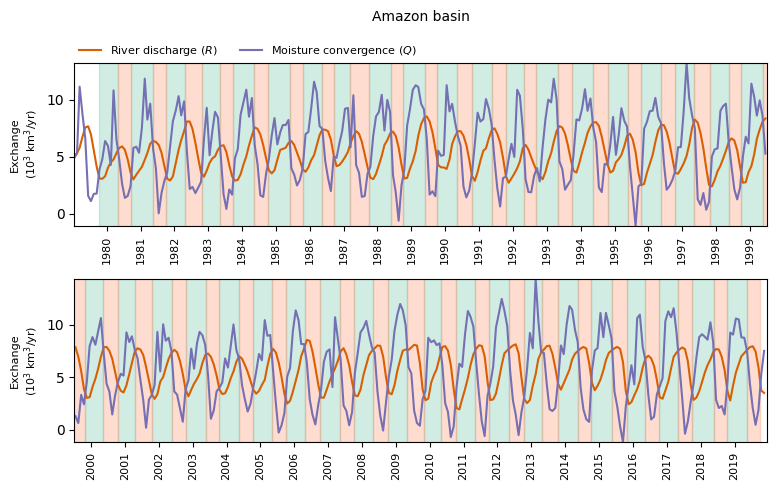

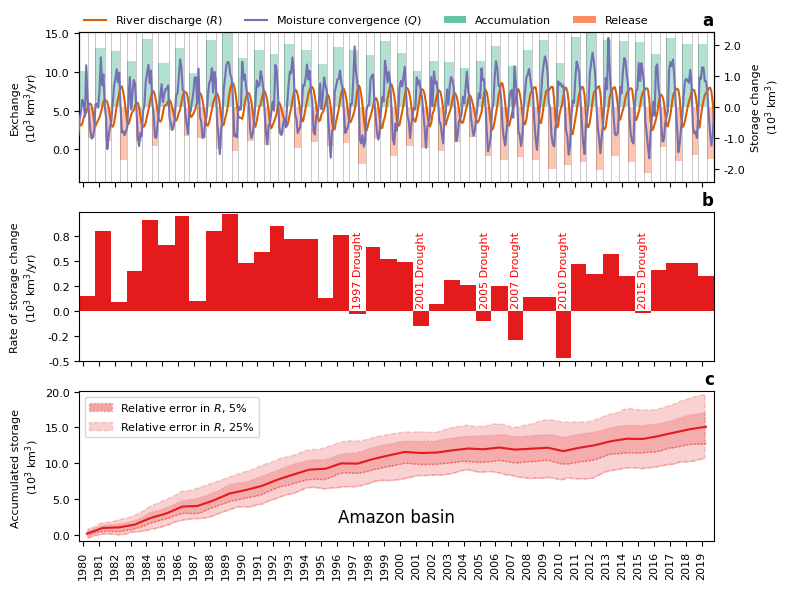

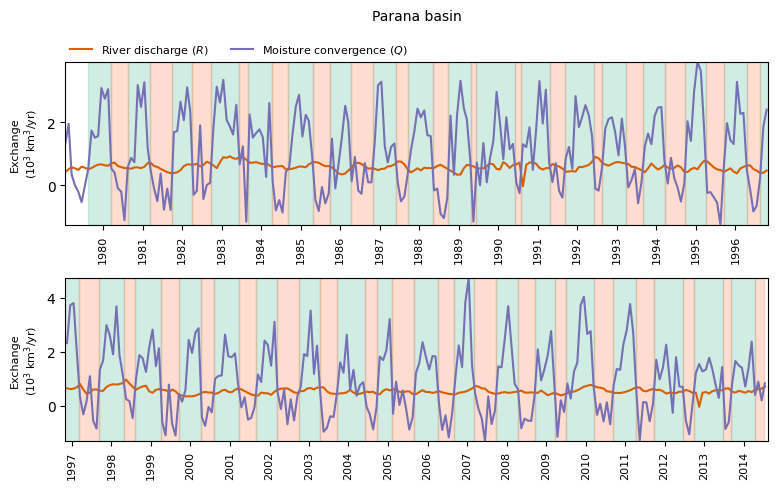

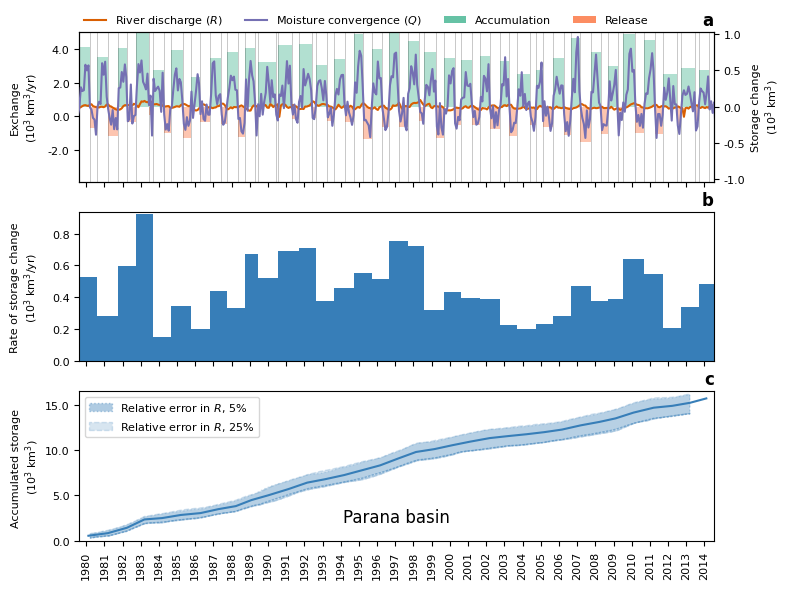

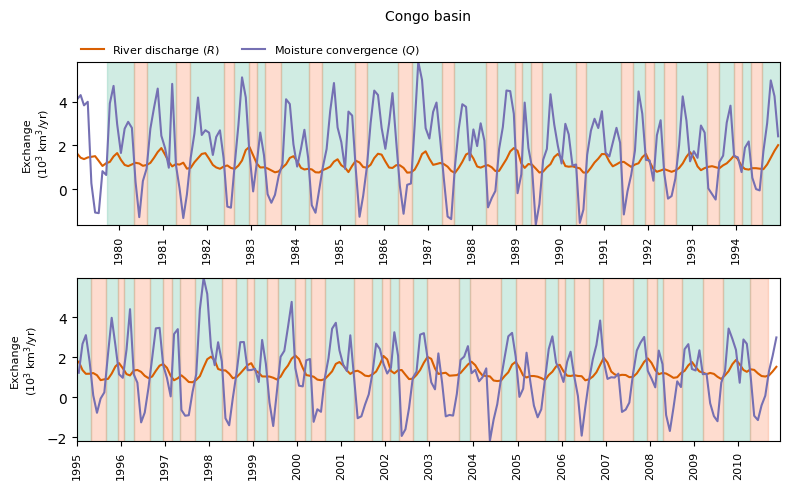

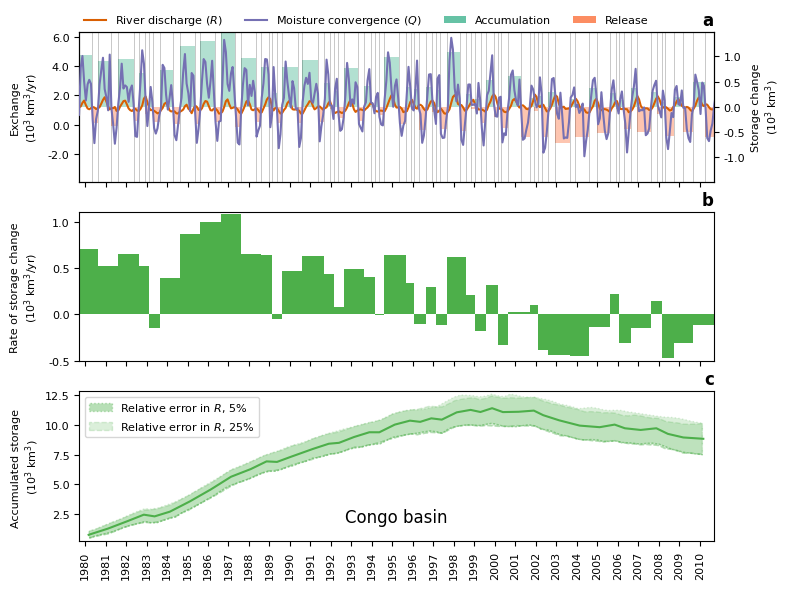

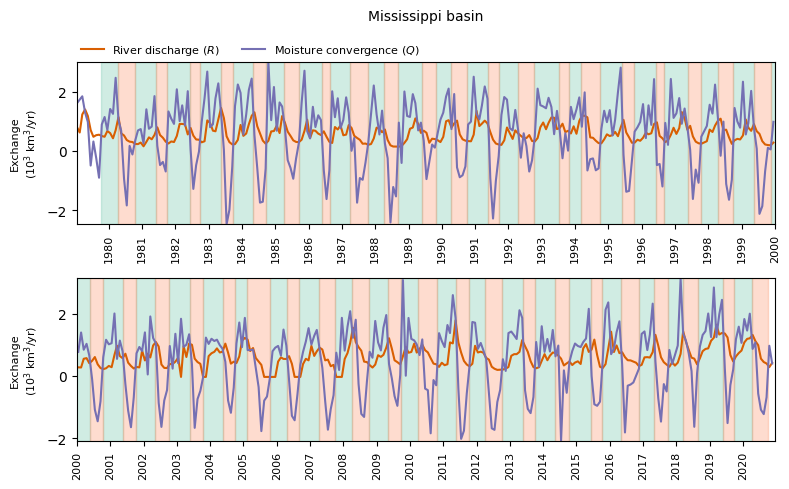

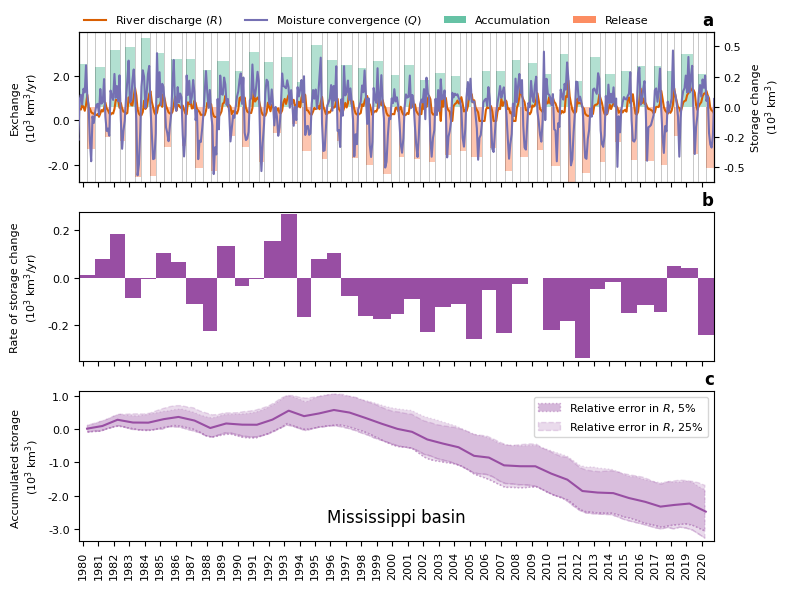

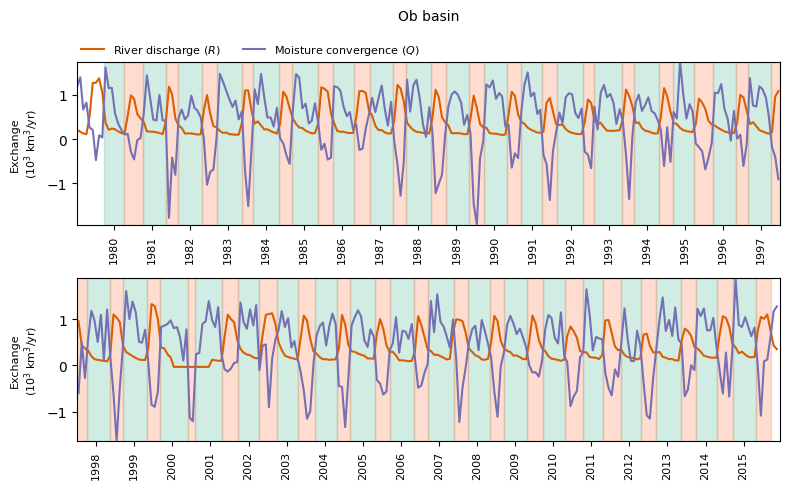

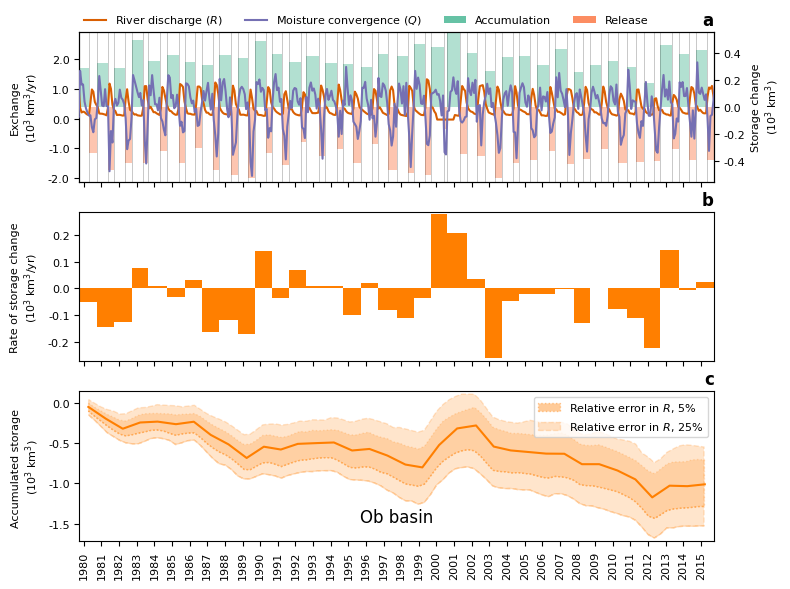

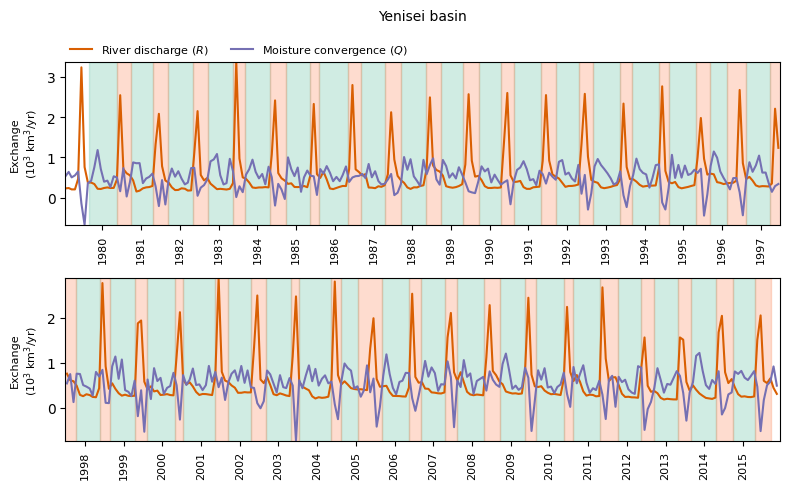

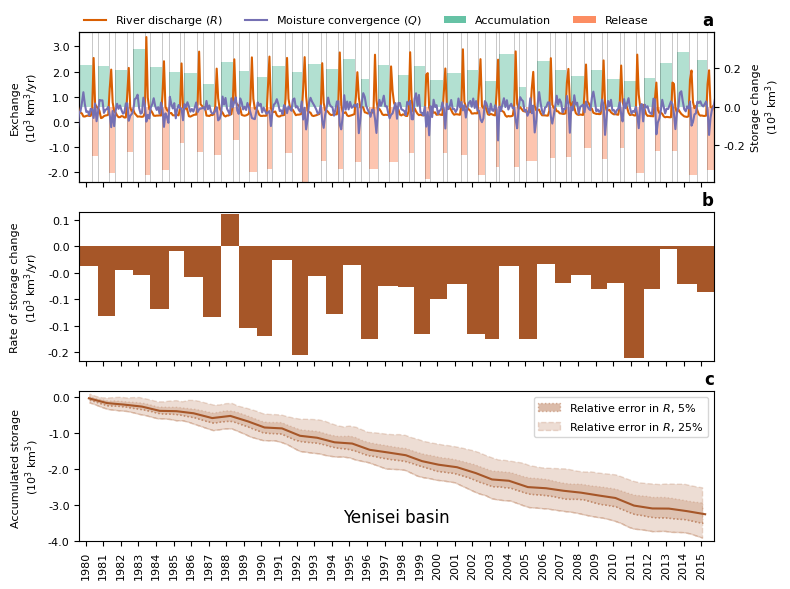

In [19]:
N=100
for key,basin in basins.items():
    modify_basin_errors(basin,vR=0.05)
    basinset1=storage_error_band(basin,seed=basin.seed,N=N)
    modify_basin_errors(basin,vR=0.25)
    basinset2=storage_error_band(basin,seed=basin.seed,N=N)
    plot_accumulation_release_storage(basin,basinsets=[basinset1,basinset2])

### Q from fluxes and errors

In [14]:
def plot_fluxdiv(basin):
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    ax.plot([basin.data["nq"].min()/UQ/UI,basin.data["nq"].max()/UQ/UI],
            [basin.data["nq"].min()/UQ/UI,basin.data["nq"].max()/UQ/UI],'k-',lw=3,alpha=0.3,
           )
    ax.errorbar(basin.data["nq"]/UQ/UI,-basin.data["nqdiv"]/UQ/UI,
                yerr=basin.data["dnqdiv"]/UQ/UI,
                capsize=2,color=basin.color,fmt="none",lw=0.5,alpha=0.3)
    ax.plot(basin.data["nq"]/UQ/UI,-basin.data["nqdiv"]/UQ/UI,'o',color=basin.color,ms=1)
    ax.set_xlabel(f"$Q$ (from lateral luxes) [{uflux}]",fontsize=8);
    ax.set_ylabel(f"$Q$ (from water vapor divergence) [{uflux}]",fontsize=8);
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.grid()
    ax.set_title(f"{basin.full}",pad=10,fontsize=12)
    ax.margins(0)
    fig.name=f"{basin.key}-fluxdiv.png"
    tight_layout(fig)
    save_fig(fig)

Saving plot as 'amazonas-fluxdiv.png'
Saving plot as 'parana-fluxdiv.png'
Saving plot as 'congo-fluxdiv.png'
Saving plot as 'mississippi-fluxdiv.png'
Saving plot as 'ob-fluxdiv.png'
Saving plot as 'yenisei-fluxdiv.png'


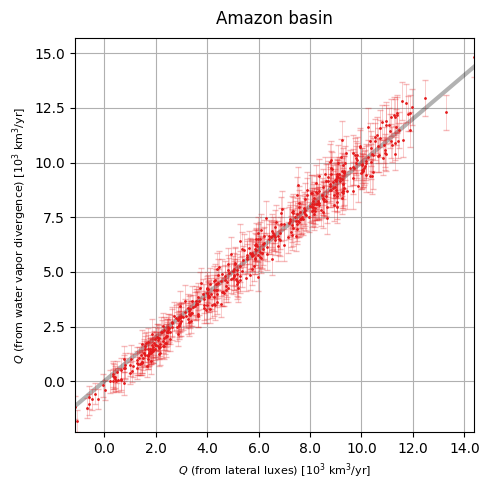

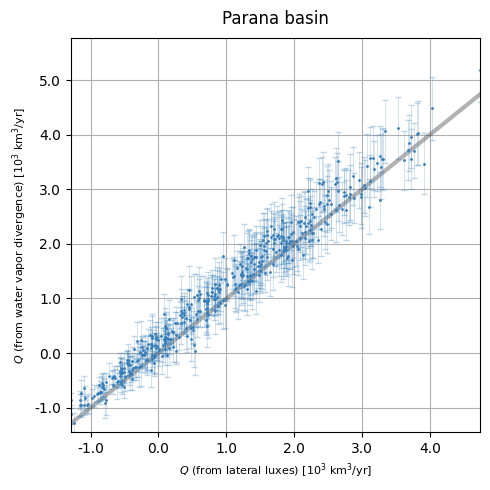

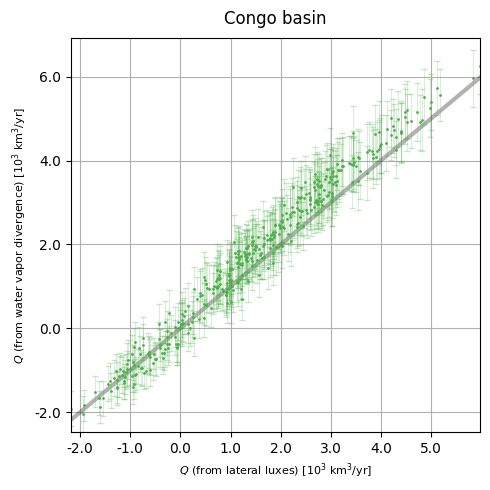

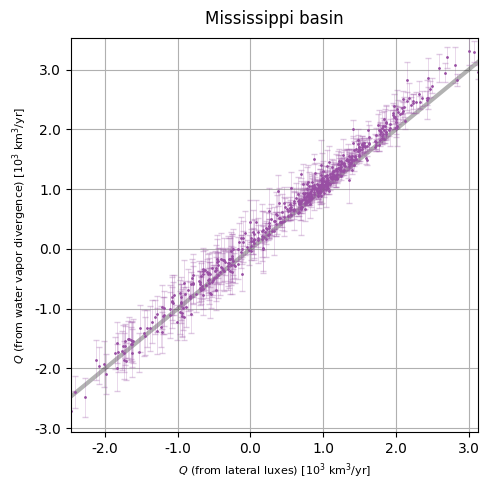

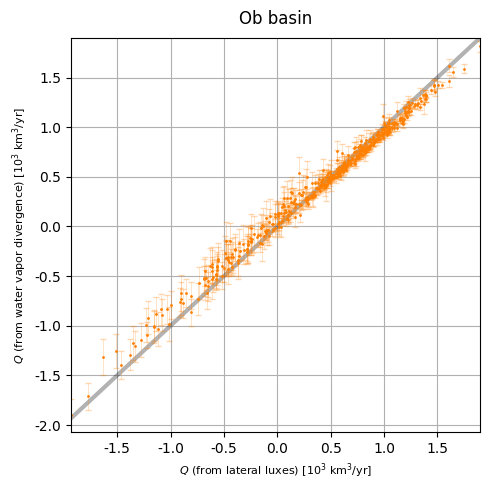

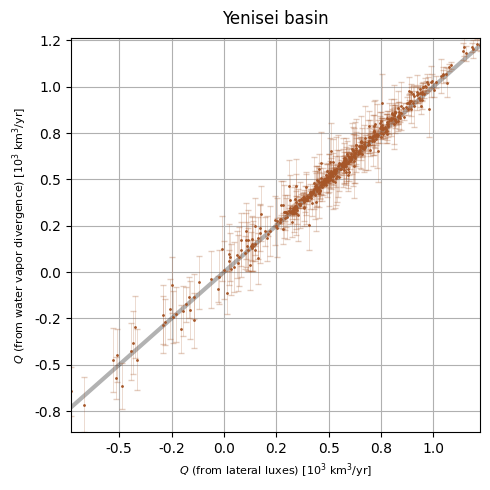

In [16]:
for key,basin in basins.items():
    plot_fluxdiv(basin)

### Explanation of accumulation release

Saving plot as 'amazonas-acc_rel-explanation'


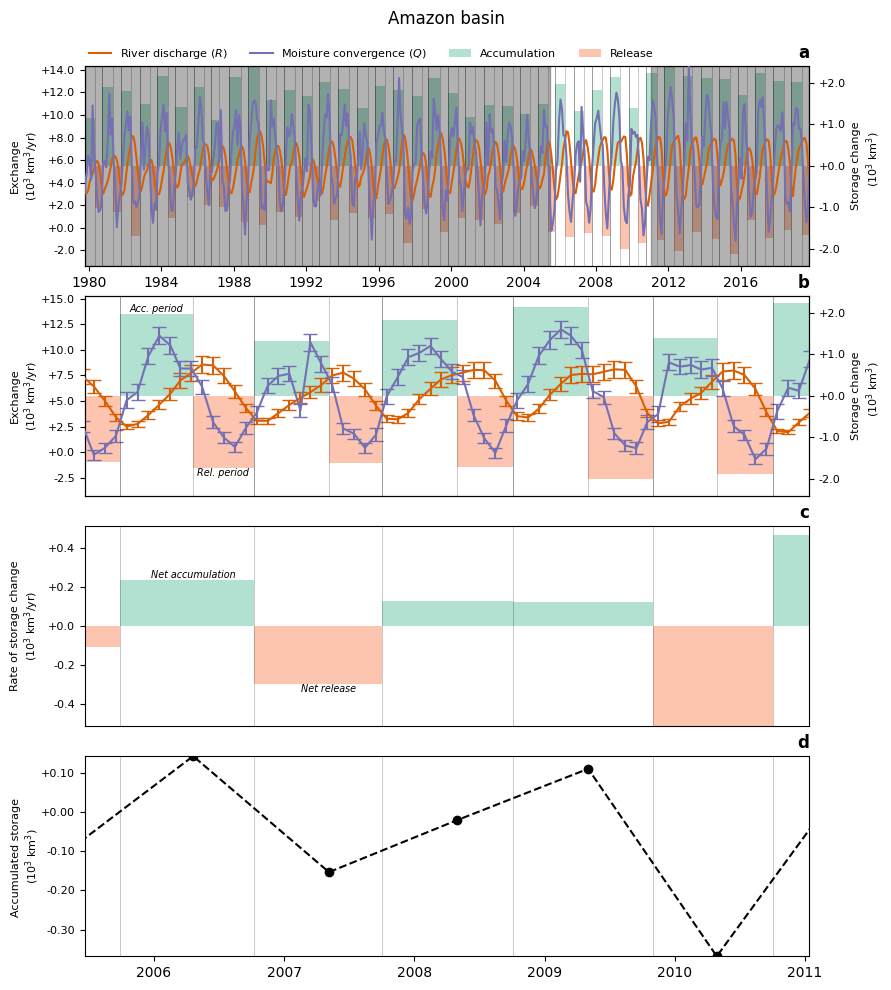

In [17]:
basin=basins["amazonas"]
bcolor='k'

#Basin data
Qs=np.array(basin.data["nq"])
Rs=np.array(basin.data["R"])
tacus=basin.tacus
trels=basin.trels
tas=basin.tas
trs=basin.trs
Ias=basin.Iacus
Irs=basin.Irels
dtas=basin.dtas
dtrs=basin.dtrs
Ss=basin.Ss
nwin=len(dtas)
dSdts=[]
for i in range(len(tacus)-1):
    dSdts+=[(Ias[i]+Irs[i])/((dtas[i]+dtrs[i])/365.25)]
dSdts=np.array(dSdts)
    
########################################
#FIGURE
########################################
plt.close("all")
Np=4
fig,axs=plt.subplots(Np,1,figsize=figsize(9,2.5*Np))

########################################
#INTERVAL
########################################
iini=-15
iend=-10
tini=tacus[iini]-100*86400
tend=tacus[iend]+100*86400
font=FontProperties()
font.set_style("italic")
font.set_size('x-small')

########################################
#EXCHANGE FULL
########################################
ax=axs[0]
ax.patch.set_visible(False)
ax.plot(basin.data["datetime"],Rs/UQ/UI,label=lab_R,zorder=1000,**sty_R)
ax.plot(basin.data["datetime"],Qs/UQ/UI,label=lab_nq,zorder=1000,**sty_nq)
ax.bar(datetime.fromtimestamp(tas[0]),1e-6*Ias[0]/UI,width=dtas[0],color=acc_color,alpha=0.5,label="Accumulation")
ax.bar(datetime.fromtimestamp(trs[0]),1e-6*Irs[0]/UI,width=dtrs[0],color=rel_color,alpha=0.5,label="Release")
for tr in trels:
    ax.axvline(datetime.fromtimestamp(tr),color='k',lw=0.5,alpha=0.3)
for ta in tacus:
    ax.axvline(datetime.fromtimestamp(ta),color='k',lw=0.5,alpha=0.3)
    
#ax.axvline(datetime.fromtimestamp(tini),color='#8da0cb',lw=3)
#ax.axvline(datetime.fromtimestamp(tend),color='#8da0cb',lw=3)
ax.axvspan(datetime.fromtimestamp(tacus[0]),datetime.fromtimestamp(tini),color='k',alpha=0.3)
ax.axvspan(datetime.fromtimestamp(tend),datetime.fromtimestamp(tacus[-1]),color='k',alpha=0.3)
    
ax.legend(loc=(0.0,1),ncol=4,frameon=False)
plt.rc('legend',fontsize=8)
ax.set_ylabel(f"""Exchange
({uflux})""",fontsize=8)
ax.margins(0)
#ax.axhline(fmean,color='m')
fmin,fmax=ax.get_ylim()
fmean=np.mean([(Rs/UQ/UI).mean()])
df=max(abs(fmax-fmean),abs(fmin-fmean))
ax.set_ylim(fmean-df,fmean+df)
ax.set_xlim(datetime.fromtimestamp(tacus[0]),datetime.fromtimestamp(tacus[-1]))

########################################
#EXCHANGE
########################################
ax=axs[1]
ax.patch.set_visible(False)
ax.plot(basin.data["datetime"],Rs/UQ/UI,label=lab_R,zorder=1000,**sty_R)
ax.plot(basin.data["datetime"],Qs/UQ/UI,label=lab_nq,zorder=1000,**sty_nq)
ax.errorbar(basin.data["datetime"],Rs/UQ/UI,yerr=basin.data["dR"]/UQ/UI,ls='None',capsize=5,**sty_R)
ax.errorbar(basin.data["datetime"],Qs/UQ/UI,yerr=basin.data["dnq"]/UQ/UI,ls='None',capsize=5,**sty_nq)
ax.bar(datetime.fromtimestamp(tas[0]),1e-6*Ias[0]/UI,width=dtas[0],color=acc_color,alpha=0.5,label="Accumulation")
ax.bar(datetime.fromtimestamp(trs[0]),1e-6*Irs[0]/UI,width=dtrs[0],color=rel_color,alpha=0.5,label="Release")
for tr in trels:
    ax.axvline(datetime.fromtimestamp(tr),color='k',lw=0.5,alpha=0.3)
for ta in tacus:
    ax.axvline(datetime.fromtimestamp(ta),color='k',lw=0.5,alpha=0.3)
ax.set_ylabel(f"""Exchange
({uflux})""",fontsize=8)
ax.margins(0)
#ax.axhline(fmean,color='m')
fmin,fmax=ax.get_ylim()
fmean=np.mean([(Rs/UQ/UI).mean()])
df=max(abs(fmax-fmean),abs(fmin-fmean))
ax.set_ylim(fmean-df,fmean+df)

########################################
#STORAGE CHANGE
########################################
axts=[]
for ax in axs[:2]:
    axt=ax.twinx()
    axts+=[axt]
    axt.set_zorder(-1)
    axt.set_ylabel(r"""Storage change
    ($10^3$ km$^3$)""",fontsize=8)
    axt.yaxis.set_major_formatter(FormatStrFormatter('%+.1f'))
    axt.tick_params(axis='y',which='major',labelsize=8)

    Imax,Imin=max(max(Ias)/UI,max(Irs)/UI),min(min(Ias)/UI,min(Irs)/UI)
    dI=max(abs(Imax),abs(Imin))
    axt.set_ylim(-dI,+dI)
    for i in range(nwin):
        axt.bar(datetime.fromtimestamp(tas[i]),Ias[i]/UI,width=dtas[i],color=acc_color,alpha=0.5)
        axt.bar(datetime.fromtimestamp(trs[i]),Irs[i]/UI,width=dtrs[i],color=rel_color,alpha=0.5)
    axt.yaxis.set_major_formatter(FormatStrFormatter('%+.1f'))
    axt.tick_params(axis='y',which='major',labelsize=8)

iexp=iini+1
axts[1].text(datetime.fromtimestamp(tas[iexp]),Ias[iexp-1]/UI,"Acc. period",
             va='bottom',ha='center',fontproperties=font)
axts[1].text(datetime.fromtimestamp(trs[iexp]),Irs[iexp]/UI,"Rel. period",
             va='top',ha='center',fontproperties=font)

########################################
#RATE
########################################
ax=axs[2]
for i in range(len(tacus)-1):
    t=(tacus[i]+tacus[i+1])/2
    if dSdts[i]>0:
        rcolor=acc_color
    else:
        rcolor=rel_color
    ax.bar(datetime.fromtimestamp(t),dSdts[i]/UI,width=dtas[i]+dtrs[i],
           color=rcolor,alpha=0.5)
ax.set_ylabel(rf"""Rate of storage change
($10^3$ km$^3$/yr)""",fontsize=8)

iexp=iini+1
ax.text(datetime.fromtimestamp(trels[iexp]),dSdts[iexp]/UI,"Net accumulation",
        va='bottom',ha='center',fontproperties=font)
iexp=iini+2
ax.text(datetime.fromtimestamp(trels[iexp]),dSdts[iexp]/UI,"Net release",
        va='top',ha='center',fontproperties=font)

########################################
#STORAGE
########################################
axa=axs[3]
dS=Ss-Ss[iini-1]
axa.plot([datetime.fromtimestamp(t) for t in trels],dS/UI,'o--',color=bcolor)
axa.set_ylabel(rf"""Accumulated storage 
($10^3$ km$^3$)""",fontsize=8)
dSrange=dS[iini-1:iend+1]/UI
axa.set_ylim(dSrange.min(),dSrange.max())

########################################
#DECORATION
########################################
#y limits
#Ivals=dSdts[(tacus>=tini)&(tacus<tend)]
Ivals=dSdts[(tacus[:-1]>=tini)&(tacus[:-1]<tend)]
Iext=max(abs(min(Ivals)/1e3),abs(max(Ivals)/1e3))
ax.set_ylim(-Iext,+Iext)

#Decoration
axs[0].set_title(f"{basin.full}",pad=30)
axs[0].legend(loc=(0.0,1),ncol=5,frameon=False);

fig.subplots_adjust(wspace=0,hspace=0)

for ax in axs:
    for ta in tacus:
        ax.axvline(datetime.fromtimestamp(ta),color='k',lw=0.5,alpha=0.3)

for ax in axs[1:]:
    ax.set_xlim(datetime.fromtimestamp(tini),datetime.fromtimestamp(tend))
    
for ax in axs[1:-1]:
    ax.set_xticks([])

labelx=-0.06
labels="abcdef"
for i,ax in enumerate(list(axs)):
    ax.yaxis.set_label_coords(labelx, 0.5)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%+.1f'))
    ax.tick_params(axis='y',which='major',labelsize=8)
    ax.text(1,1.02,labels[i],
            fontsize=12,ha='right',va='bottom',transform=ax.transAxes,fontweight="bold")

axs[3].yaxis.set_major_formatter(FormatStrFormatter('%+.2f'))
    
#SAVE IMAGES
fig.name=f"{basin.key}-acc_rel-explanation"
tight_layout(fig)
fig.subplots_adjust(wspace=0.0,hspace=0.15)
save_fig(fig)

### Annual cycles

In [63]:
def foldingSignal(pars,fint=None, # Mandatory
                  yini=None,yend=None, # Optional
                  plot=False,iper=1,nover=10,ylabel=r"Signal" # Decorative
                 ):
    """
    Creates a folded plot of a time series.

    Parameters:
      pars: Folding parameters:
        t0: initial time [days] (float)
        T: Period [days] (float)

      fint: Interpolating function, fint(t) where t is in seconds, returns the signal at time t.
        It should be an instance of scipy.interpolate.interp1d
        
      iper = 0: number of annual cycles to show (zero, if no annual cycles shown)
      
      nover = 10: Oversampling frequency of interpolation
      
      yini, yend: years of start and end of folding
      
      ylabel = "Signal": ylabel of plot.

    Returns:

      phases: phases (array, Nsam)
      
      fsam: annual cycle average and limits (array, Nsam x 3):
        column 0: 10% quantile
        column 1: median
        column 2: 90% quantile
        
      error: error in folding (signal - fsam)/average
    """

    #Parameters
    t0=pars[0] #days
    T=pars[1] #days

    #Initial time in days
    times=fint.x
    if yini is not None:
        tini=datetime(yini,1,1,0,0,0).timestamp()+UTCL
    else:
        tini=times[0]
    if yend is not None:
        tend=datetime(yend,1,1,0,0,0).timestamp()+UTCL
    else:
        tend=times[-1]
    
    #Indexes corresponding to year intervals
    ies=np.arange(len(times))
    mini=ies[times>=tini][0]
    mend=ies[times<=tend][-1]

    #Initial time
    ti=t0+times[mini]/days

    #Interpolating values
    tds=np.linspace(times[mini]/days,times[mend]/days,nover*(mend-mini))
    fints=fint(tds*days)

    #Phases
    phs=np.mod((tds-ti)/T,1)

    #Sampling phases
    Nsam=100
    phsams=np.linspace(0,1,Nsam)
    dph=phsams[1]-phsams[0]

    #Averaging 
    fsam=np.zeros((Nsam,3))
    for i,ph in enumerate(phsams):
        cond=(phs<=(ph+dph))&(phs>(ph-dph))
        fsam[i]=np.quantile(fints[cond],[0.1,0.50,0.90])
    error=abs(fsam[:,2]-fsam[:,0]).sum()/abs(fsam[:,1].mean())

    if plot:
        #Plot folded
        """
        fig=plt.figure()
        ax=fig.gca()
        if iper:
            ax.scatter(phs[::iper],fints[::iper],s=0.1)
        ax.plot(phsams,fsam[:,1],'r-')
        ax.fill_between(phsams,y1=fsam[:,0],y2=fsam[:,2],color='r',alpha=0.3)

        #Decoration
        ax.set_title("Folded signal, $t_0$ = "+f"{t0:.2f} days, T = {T:.2f} days [{error:.2f}]",fontsize=10)
        ax.set_xlabel(r"Cycle phase, $\phi$")
        ax.set_ylabel(ylabel)
        ax.set_xlim((0,1))
        fig.tight_layout()
        """
        return phsams,fsam,error
    else:
        return error
    
def foldingOptimal(fint,yini=None,yend=None,nover=30,pdays=30,plot=False):

    #Minimization method
    method="COBYLA"

    #Travel through year finding the best period that minimize variances in folding
    fmin=1e100
    for i,d0 in enumerate(tqdm(np.linspace(0,365,pdays),position=0)):
        sol=minimize(foldingSignal,[d0,365.25],method=method,args=(fint,yini,yend,False,0,nover,""),tol=1e-9)
        if sol.fun<fmin:
            fit=sol
            fmin=sol.fun
  
    #Plot best bit
    plot=True
    phsams,fsam,error=foldingSignal(fit.x,fint,yini,yend,plot,0,nover,"Folded")
    phsams,fsam,error=foldingSignal([0,365.25],fint,yini,yend,plot,0,nover,"Initial")
    
    return fit.x,None,phsams,fsam,error

def AnnualCycle(basin):

    #############################################
    #DATA
    #############################################
    ts=np.array(basin.data["time"])
    Qs=np.array(basin.data["nq"])/UQ/UI
    Rs=np.array(basin.data["R"])/UQ/UI
    
    Qmean=Qs.mean()
    Rmean=Rs.mean()

    kind_interp="slinear"
    basin.Rint=interp1d(ts,Rs,kind=kind_interp)
    basin.nqint=interp1d(ts,Qs,kind=kind_interp)
    
    #############################################
    #FOLDING
    #############################################
    fit_nq,adj_nq,phsams_nq,fsam_nq,error_nq=foldingOptimal(basin.nqint)
    fit_R,adj_R,phsams_R,fsam_R,error_R=foldingOptimal(basin.Rint)
        
    #############################################
    #ANNUAL CYCLE PLOT
    #############################################
    fig,axs=plt.subplots(1,1)
    ax=axs
    ax.plot(phsams_R,fsam_R[:,1],color=Rcolor,label="River discharge (R)")
    ax.fill_between(phsams_R,fsam_R[:,0],fsam_R[:,2],color=Rcolor,alpha=0.2)
    ax.axhline(Rmean,ls="--",lw=2,color=Rcolor)
    ax.plot(phsams_nq,fsam_nq[:,1],color=Qcolor,label="Moisture convergence (Q)")
    ax.fill_between(phsams_nq,fsam_nq[:,0],fsam_nq[:,2],color=Qcolor,alpha=0.2)
    ax.axhline(Qmean,ls="--",lw=2,color=Qcolor)
    ax.legend(loc=(0.0,1),ncol=4,frameon=False,fontsize=10)    
    ax.set_ylabel(f"""Exchange
({uflux})""",fontsize=12)
    ax.margins(0)
    ymin,ymax=ax.get_ylim()
    ax.set_ylim(ymin,ymax*1.2)
    ax.set_xlabel(f"""Phase""",fontsize=12)
    ax.text(0.5,0.95,f"""{basin.full}""",va="top",ha="center",fontsize=12,transform=ax.transAxes)
    ax.text(0.5,0.90,rf"""Global imbalance $\langle Q\rangle-\langle R\rangle$ = {Qmean-Rmean:+.3f}$\times 10^3$ km$^3$/yr""",va="top",ha="center",fontsize=8,transform=ax.transAxes)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    #SAVE IMAGES
    fig.name=f"{basin.key}-annual_cycle"
    tight_layout(fig)
    fig.subplots_adjust(wspace=0.0,hspace=0.15)
    save_fig(fig)

100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Saving plot as 'amazonas-annual_cycle'


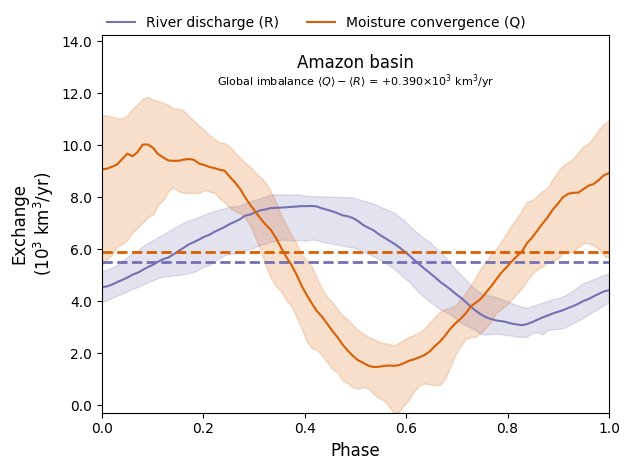

In [64]:
AnnualCycle(basins["amazonas"])
#AnnualCycle(basins["mississippi"])

100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Saving plot as 'amazonas-annual_cycle'


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Saving plot as 'parana-annual_cycle'


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


Saving plot as 'congo-annual_cycle'


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Saving plot as 'mississippi-annual_cycle'


100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


Saving plot as 'ob-annual_cycle'


100%|██████████| 30/30 [00:09<00:00,  3.02it/s]


Saving plot as 'yenisei-annual_cycle'


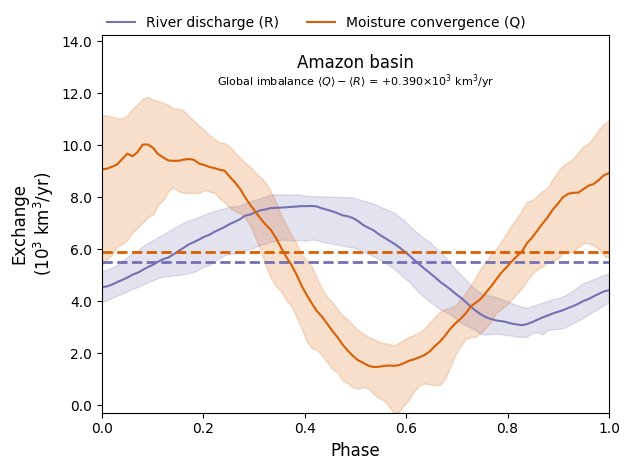

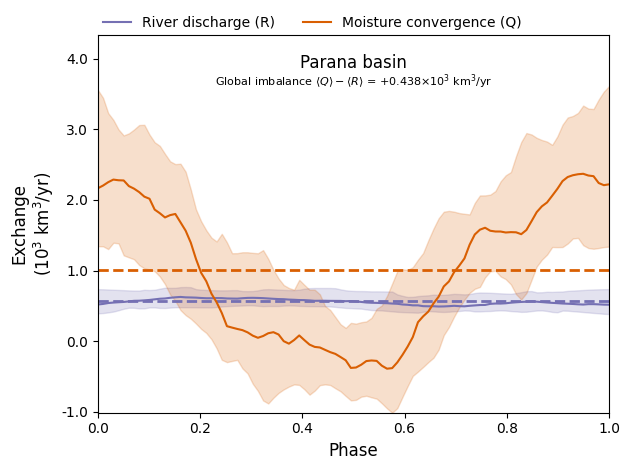

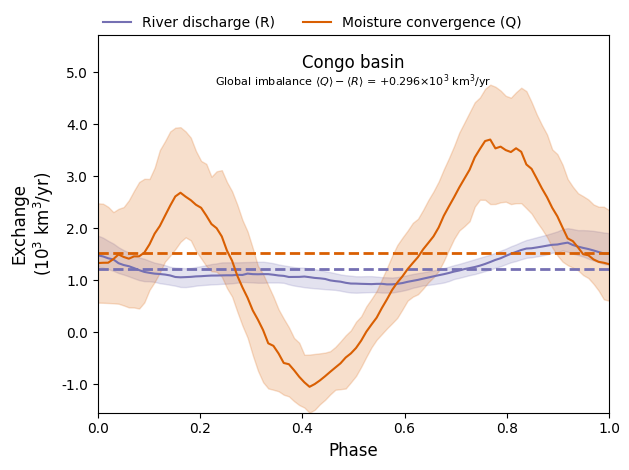

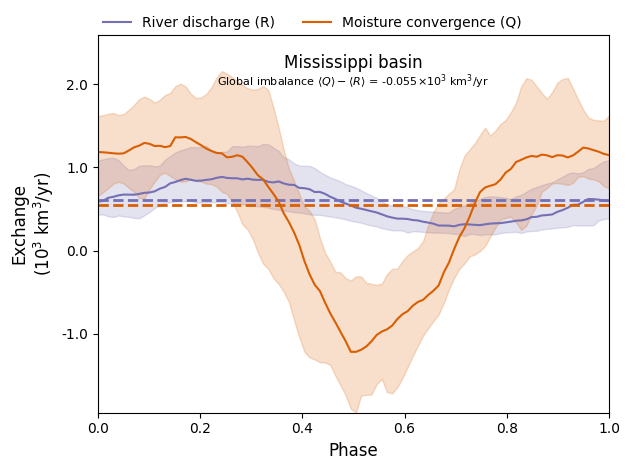

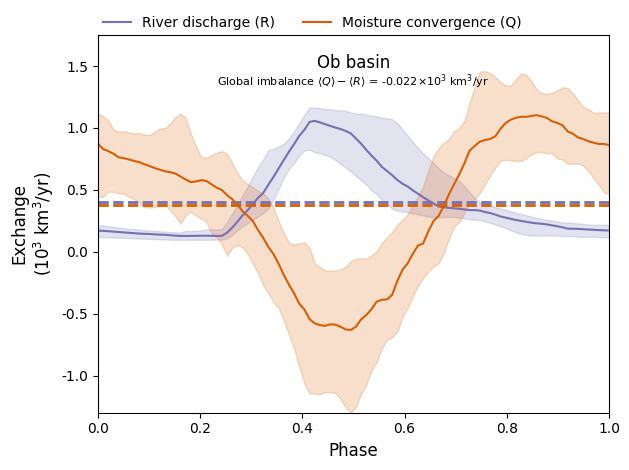

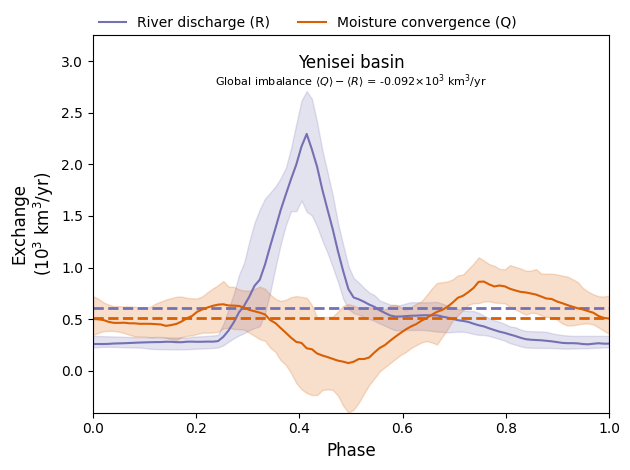

In [65]:
for key,basin in basins.items():
    AnnualCycle(basin)